# Compare LIME & ICA Explainability

In [15]:
# load packages
import numpy as np
from sklearn.svm import SVC
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import FastICA, TruncatedSVD, PCA, NMF
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

In [16]:
# load tweets
tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

# Train Classifier

In [17]:
# load ICA embeddings
embedded_tweets = np.load('tweet_embed_250.npy')

In [18]:
# instantiate classification algorithm

# round 1 winner
svc = SVC(C = 1, kernel = 'rbf', probability = True)

class1_train_indices = list(range(100))
class0_train_indices = list(range(280,380))

train_X = embedded_tweets[[class1_train_indices + class0_train_indices],:][0]

hundred_ones = [1]*100
hundred_zeros = [0]*100
train_Y = hundred_ones + hundred_zeros

# fit SVC model on training subset of tweet embeddings
svc.fit(train_X, train_Y)

SVC(C=1, probability=True)

## Disaggregate correct/incorrect predictions

### Unreliable tweets

In [19]:
# get test set
test_indices = list(range(100,280))
test_X = embedded_tweets[[test_indices],:][0]

# model predictions for test set
y_hat = svc.predict(test_X)

In [20]:
# correct or not
y_bool_unrel = y_hat==1

In [21]:
unrel_indx = [123,169,245,266,278]

for i in unrel_indx:
    print(y_bool_unrel[i-100])

True
True
True
True
True


### Reliable tweets

In [22]:
# get test set
test_indices = list(range(380,560))
test_X = embedded_tweets[[test_indices],:][0]

# model predictions for test set
y_hat = svc.predict(test_X)

In [23]:
# correct or not
y_bool_rel = y_hat==0

In [24]:
rel_indx = [389,402,410,472,517]

for i in rel_indx:
    print(y_bool_rel[i-380])

True
True
True
True
True


# LIME explanations

In [25]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [26]:
# to convert contractions picked up by word_tokenize() into full words
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is', # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}

# to convert nltk_pos tags to wordnet-compatible PoS tags
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
                
    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]

In [27]:
class Text2Embed(TransformerMixin):
    """ Description:
        Transformer that takes in a list of strings, calculates the word-context matrix
        (with any specified transformations), reduces the dimensionality of these word
        embeddings, and then provides the text embeddings of a (new) list of texts
        depending on which words in the "vocab" occur in the (new) strings.
    """

    # initialize class & private variables
    def __init__(self,
                 window_size=4,
                 remove_stopwords=True,
                 add_start_end_tokens=True,
                 lowercase=False,
                 lemmatize=False,
                 pmi=False,
                 spmi_k=1,
                 laplace_smoothing=0,
                 pmi_positive=False,
                 sppmi_k=1,
                 n_components=250,
                 random_state=4):

        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                spmi_k: numeric, shifted pmi value
                pmi_positive: boolean, whether or not to compute positive PMI
                sppmi_k: numeric, shifted ppmi value
                n_components: number of components for PCA/FastICA
                random_state: set seed for FastICA
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
        self.ica = FastICA(n_components=n_components, random_state=random_state)
        self.scaler = StandardScaler()
        self.word_embeddings = None
        self.text_embeddings = None

    def fit(self, corpus, y=None):

        """ Learn the dictionary of all unique tokens for given corpus. Compute the co-occurrence matrix
            for input corpus and window_size, using term dictionary. Reduce dimensionality of embeddings.

            Params:
                corpus: list of strings

            Returns: self
        """
        self.corpus = corpus

        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()

        for text in corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)

            words = word_tokenize(text)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)

            [corpus_words.append(word) for word in words]

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            doc_terms_lists.append(words)

        self.clean_corpus = clean_corpus

        self.doc_terms_lists = doc_terms_lists

        corpus_words = list(set(corpus_words))

        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']

        corpus_words = sorted(corpus_words)

        for el in corpus_words:
            term_dict[el] = k
            k += 1

        self.vocabulary = term_dict

        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)

        for el in range(len(clean_corpus)):
            words = doc_terms_lists[el]

            # Construct word-context matrix
            for i in range(len(words)):
                target = words[i]

                # grab index from dictionary
                target_dict_index = self.vocabulary[target]

                # find left-most and right-most window indices for each target word
                left_end_index = max(i - window, 0)
                right_end_index = min(i + window, len(words) - 1)

                # loop over all words within window
                # NOTE: this will include the target word; make sure to skip over it
                for j in range(left_end_index, right_end_index + 1):

                    # skip "context word" where the "context word" index is equal to the
                    # target word index
                    if j != i:
                        context_word = words[j]

                        # count co-occurrence of target and context words
                        X[target_dict_index, self.vocabulary[context_word]] += 1

        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis=0)
            row_sums = X.sum(axis=1)

            expected = np.outer(row_sums, col_sums) / denom

            X = X / expected

            for i in range(X.shape[0]):
                for j in range(X.shape[1]):

                    if X[i, j] > 0:
                        X[i, j] = np.log(X[i, j]) - np.log(self.spmi_k)

                        if self.pmi_positive:
                            X[i, j] = max(X[i, j] - np.log(self.sppmi_k), 0)

        # note that X is a dense matrix
        self.X = X

        word_embeddings = self.scaler.fit_transform(self.X)
        word_embeddings = self.ica.fit_transform(word_embeddings)

        # transformed WordICA embeddings
        self.word_embeddings = word_embeddings

        return self

    def transform(self, new_corpus=None, y=None):

        """ Get text embeddings for given corpus, using term dictionary and word embeddings obtained
            with fit method.

            Returns: text embeddings (shape: num texts by embedding dimensions)
        """
        lemmatizer = WordNetLemmatizer()
        #if type(new_corpus) != list:
            #exit()

        for k in range(len(new_corpus)):
            text = new_corpus[k]
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            text_vec = np.zeros(self.word_embeddings.shape[1])
            words = word_tokenize(text)
            tracker = 0  # to track whether we've encountered a word for which we have an embedding (in each tweet)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            for i in range(len(words)):
                word = words[i]
                if word in self.vocabulary:
                    word_embed_vec = self.word_embeddings[self.vocabulary[word], :]
                    if tracker == 0:
                        text_matrix = word_embed_vec
                    else:
                        text_matrix = np.vstack((text_matrix, word_embed_vec))

                    # only increment if we have come across a word in the embeddings dictionary
                    tracker += 1

            for j in range(len(text_vec)):
                text_vec[j] = text_matrix[:, j].mean()

            if k == 0:
                full_matrix = text_vec
            else:
                full_matrix = np.vstack((full_matrix, text_vec))

        self.text_embeddings = full_matrix

        return self.text_embeddings.copy()

embedded_tweets = np.load('tweet_embed_250.npy')

# instantiate embedder
embedder = Text2Embed(window_size = 15, lowercase = True, lemmatize = True, pmi = True)
embedder.fit(tweets['Tweet'])

In [28]:
c = make_pipeline(embedder, svc)
explainer = LimeTextExplainer(class_names = ['Reliable', 'Unreliable'])

In [29]:
exp = explainer.explain_instance(tweets['Tweet'][527], c.predict_proba, num_features = 6)

In [30]:
exp.as_list()

[('COVID', -0.2116507101118955),
 ('19', -0.20702862796331625),
 ('lot', 0.08375831349689944),
 ('fear', -0.07376291603838021),
 ('coronavirus', -0.04541129197736844),
 ('town', 0.034125689973761246)]

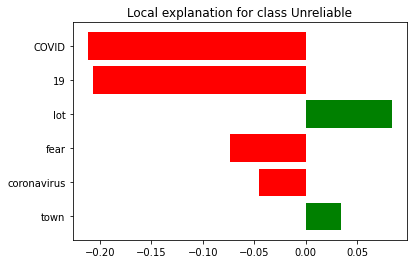

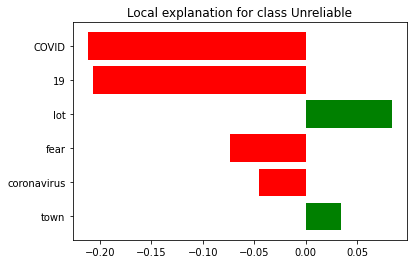

In [31]:
exp.as_pyplot_figure()

In [33]:
#np.array(correctUnrelExp[0])[:,1]

# Create Word Context Embeddings

In [34]:
class ContextMatrix(TransformerMixin):
    
    # initialize class & private variables
    def __init__(self,
                 window_size = 4,
                 remove_stopwords = True,
                 add_start_end_tokens = True,
                 lowercase = False,
                 lemmatize = False,
                 pmi = False,
                 spmi_k = 1,
                 laplace_smoothing = 0,
                 pmi_positive = False,
                 sppmi_k = 1):
        
        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                pmi_positive: boolean, whether or not to compute positive PMI
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
    
    def fit(self, corpus, y = None):
        
        """ Learn the dictionary of all unique tokens for given corpus.
        
            Params:
                corpus: list of strings
            
            Returns: self
        """
        self.corpus = corpus
        
        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()
        
        for text in corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            
            words = word_tokenize(text)
            
            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words
                
            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())
                
                words = clean_words
                
            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]
                    
                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)
                    
                words = clean_words
            
            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)
            
            [corpus_words.append(word) for word in words]
            
            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']
            
            doc_terms_lists.append(words)
            
        self.clean_corpus = clean_corpus
        
        self.doc_terms_lists = doc_terms_lists
        
        corpus_words = list(set(corpus_words))
        
        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']
        
        corpus_words = sorted(corpus_words)
        
        for el in corpus_words:
            term_dict[el] = k
            k += 1
            
        self.vocabulary = term_dict
        
        return self
        
    def transform(self, new_corpus = None, y = None):
        
        """ Compute the co-occurrence matrix for given corpus and window_size, using term dictionary
            obtained with fit method.
        
            Returns: term-context co-occurrence matrix (shape: target terms by context terms) with
            raw counts
        """
        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)
        
        lemmatizer = WordNetLemmatizer()
        if type(new_corpus) != list:
            new_corpus = self.corpus
        
        for text in new_corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            
            words = word_tokenize(text)
            
            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words
                
            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())
                
                words = clean_words
                
            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]
                    
                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)
                    
                words = clean_words
                
            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']
            
            for i in range(len(words)):
                target = words[i]
                
                # check to see if target word is in the dictionary; if not, skip
                if target in self.vocabulary:
                    
                    # grab index from dictionary
                    target_dict_index = self.vocabulary[target]
                    
                    # find left-most and right-most window indices for each target word
                    left_end_index = max(i - window, 0)
                    right_end_index = min(i + window, len(words) - 1)
                    
                    # loop over all words within window
                    # NOTE: this will include the target word; make sure to skip over it
                    for j in range(left_end_index, right_end_index + 1):
                        
                        # skip "context word" where the "context word" index is equal to the
                        # target word index
                        if j != i:
                            context_word = words[j]
                            
                            # check to see if context word is in the fitted dictionary; if
                            # not, skip
                            if context_word in self.vocabulary:
                                X[target_dict_index, self.vocabulary[context_word]] += 1
        
        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis = 0)
            row_sums = X.sum(axis = 1)
            
            expected = np.outer(row_sums, col_sums)/denom
            
            X = X/expected
            
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                
                    if X[i,j] > 0:
                        X[i,j] = np.log(X[i,j]) - np.log(self.spmi_k)
                        
                        if self.pmi_positive:
                            X[i,j] = max(X[i,j] - np.log(self.sppmi_k), 0)
        
        # note that X is a dense matrix
        self.X = X

        return X

In [35]:
cm = ContextMatrix(window_size = 15, lowercase = True, lemmatize = True, pmi = True)

In [36]:
word_context_matrix = cm.fit_transform(tweets['Tweet'])

In [37]:
pd.DataFrame(word_context_matrix, index = cm.vocabulary, columns = cm.vocabulary)

,!,#,(,),",",-,--,.,..,...,...,zombie,zone,zoomer,zuckerberg,—,‘,’,“,”,❝real
!,2.531314,-0.503127,0.000000,-1.483746,-1.146376,-0.470562,0.000000,-0.373401,0.00000,1.658890,...,0.000000,0.000000,0.000000,0.0,0.272595,0.000000,0.610607,0.747004,-0.331541,1.738932
#,-0.503127,0.957290,-0.869089,-0.901879,-0.432241,-0.240093,-0.199199,-0.144481,0.52904,-1.342762,...,0.000000,-0.569572,0.223658,0.0,-0.649615,-0.257793,-0.262813,-1.338357,-1.253751,0.000000
(,0.000000,-0.869089,0.080202,2.820001,-0.141311,-0.731163,0.000000,-0.228537,0.00000,1.110606,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.566285,-0.494426,0.000000,0.000000
),-1.483746,-0.901879,2.820001,0.014623,-0.174101,-0.763953,0.000000,-0.098808,0.00000,1.077817,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.599075,-0.527216,0.000000,0.000000
",",-1.146376,-0.432241,-0.141311,-0.174101,0.127678,-0.339572,0.448537,-0.105209,0.00000,-0.289562,...,1.736391,-0.209519,0.000000,0.0,-0.289562,-0.185422,-0.239232,0.120309,-0.200550,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
‘,0.000000,-0.257793,0.000000,0.000000,-0.185422,0.000000,0.000000,-0.253229,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.666872,0.000000,0.000000,0.000000
’,0.610607,-0.262813,-0.566285,-0.599075,-0.239232,-0.279038,0.000000,0.029432,0.00000,0.869584,...,0.000000,0.000000,0.000000,0.0,0.000000,1.666872,0.802131,0.730889,0.958596,1.237309
“,0.747004,-1.338357,-0.494426,-0.527216,0.120309,0.485967,1.274076,-0.110018,0.00000,1.229125,...,0.000000,0.000000,0.000000,0.0,1.229125,0.000000,0.730889,1.010387,2.927574,0.000000
”,-0.331541,-1.253751,0.000000,0.000000,-0.200550,0.388252,1.581826,-0.070532,0.00000,1.536875,...,0.000000,0.000000,0.000000,0.0,1.536875,0.000000,0.958596,2.927574,2.319033,0.000000


In [38]:
word_context_matrix.shape

(2327, 2327)

# Word embedding interpretability

In [39]:
ica = FastICA(n_components = 250, random_state = 4)
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(word_context_matrix)
embeddings = ica.fit_transform(X_std)

In [40]:
pd.DataFrame(embeddings, index = cm.vocabulary, columns = ['Topic {}'.format(i+1) for i in range(250)])

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 241,Topic 242,Topic 243,Topic 244,Topic 245,Topic 246,Topic 247,Topic 248,Topic 249,Topic 250
!,-0.018764,0.032525,0.015407,0.009157,0.014125,0.030538,0.043033,-0.021040,-0.004332,-0.008598,...,0.010041,0.009298,0.035440,-0.000282,-0.217032,-0.135531,-0.014149,-0.002041,0.023375,0.012812
#,-0.001960,0.038517,0.010817,-0.079002,0.010372,0.080606,-0.004860,0.002473,-0.005619,-0.001717,...,-0.005194,-0.037717,0.029850,-0.002985,-0.000654,-0.010842,-0.116837,0.022335,-0.002944,0.012674
(,-0.005236,0.007737,0.004173,0.003378,0.009708,-0.197379,0.064630,-0.008035,-0.000175,0.007928,...,-0.000881,-0.011962,-0.038069,-0.006983,0.003293,-0.003806,0.024025,0.011904,-0.000179,0.012640
),-0.005141,0.009326,0.004000,0.003023,0.009742,-0.192747,0.107004,-0.008387,-0.001618,0.008576,...,-0.000223,-0.010377,-0.035645,-0.006858,0.002913,-0.002493,0.023433,0.010823,-0.000285,0.013780
",",0.005696,-0.020444,0.010301,-0.009947,-0.015616,-0.028876,0.068807,0.029133,0.008748,0.002209,...,0.007283,0.044907,0.005122,-0.045353,-0.001367,0.013397,-0.012996,-0.016318,-0.005606,-0.005031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
‘,-0.004653,-0.000871,-0.004893,-0.007177,0.005050,0.013345,0.005497,0.009252,-0.004917,-0.001666,...,0.009270,-0.002894,0.001317,-0.014909,-0.002056,-0.000942,0.000207,0.021728,-0.004728,0.004189
’,-0.020318,-0.011916,-0.010054,-0.007211,-0.018799,-0.010868,-0.004023,-0.022962,0.064756,0.031455,...,-0.058205,0.035277,0.006492,0.009137,0.016892,0.062706,0.021387,-0.002337,0.006014,-0.014130
“,0.138389,0.008750,0.022160,-0.000766,-0.023548,0.028208,-0.003127,-0.011791,-0.004823,0.008236,...,0.000869,-0.001796,-0.037675,0.006247,-0.001588,-0.002131,0.013262,-0.025095,-0.006124,0.008645
”,0.174268,0.012348,0.001448,-0.005890,-0.014411,0.006477,0.000497,-0.009226,-0.003290,0.012056,...,-0.000187,-0.003730,-0.002160,0.009387,0.002483,-0.008567,0.014139,-0.018222,-0.002453,-0.000633


In [41]:
# average magnitude of each term over all ICA components
avg_mag = np.mean(np.abs(embeddings), axis = 1)

In [42]:
termMagDF = pd.DataFrame(avg_mag, index = cm.vocabulary, columns = ['Avg_Magnitude'])
termMagDF

,Avg_Magnitude
!,0.020018
#,0.021876
(,0.016719
),0.016697
",",0.022754
...,...
‘,0.010974
’,0.025419
“,0.016581
”,0.013882


In [43]:
termMagDF.sort_values(by = 'Avg_Magnitude', ascending = False, inplace = True)
termMagDF

,Avg_Magnitude
covid-19,0.027399
:,0.026239
’,0.025419
spread,0.025008
say,0.024325
...,...
name,0.002286
travel-related,0.001981
kuwait,0.001959
classifies,0.001814


In [44]:
termMagDF['rank'] = termMagDF['Avg_Magnitude'].rank(ascending = False)
termMagDF

,Avg_Magnitude,rank
covid-19,0.027399,1.0
:,0.026239,2.0
’,0.025419,3.0
spread,0.025008,4.0
say,0.024325,5.0
...,...,...
name,0.002286,2323.0
travel-related,0.001981,2324.0
kuwait,0.001959,2325.0
classifies,0.001814,2326.0


## Extract list of words from tweet

In [45]:
# define function to get string embeddings from word embeddings

def get_tweet_words(text, # string to extract list of words from
                    remove_stopwords = True,
                    lowercase = True,
                    lemmatize = True,
                    add_start_end_tokens = True): # array of avg. word magnitudes where index matches term dict. val
    
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
    words = word_tokenize(text)
    
    if remove_stopwords:
        clean_words = []
        for word in words:
            if word.lower() not in set(stopwords.words('english')):
                clean_words.append(word)
        words = clean_words

    if lowercase:
        clean_words = []
        for word in words:
            clean_words.append(word.lower())

        words = clean_words

    if lemmatize:
        clean_words = []
        for word in words:
            PoS_tag = pos_tag([word])[0][1]

            # to change contractions to full word form
            if word in contractions:
                word = contractions[word]

            if PoS_tag[0].upper() in 'JNVR':
                word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
            else:
                word = lemmatizer.lemmatize(word)

            clean_words.append(word)

        words = clean_words

    if add_start_end_tokens:
        words = ['<START>'] + words + ['<END>']
            
    return words

## Match tweet words to word magnitudes

In [46]:
# Tweet 2
termMagDF.loc[get_tweet_words(tweets['Tweet'][1])].sort_values(by = 'rank')

,Avg_Magnitude,rank
",",0.022754,9.0
canada,0.021621,13.0
.,0.020725,21.0
u,0.020473,22.0
government,0.018218,34.0
chinese,0.017571,42.0
bad,0.015694,76.0
<END>,0.014886,91.0
<START>,0.014365,108.0
coronavirus,0.013995,122.0


# Compare ICA & LIME explanations

In [47]:
# pick unreliable tweets w indices between 100,280
print("Unreliable tweets:")
for i in unrel_indx:
    print(tweets['Tweet'][i])
    print('\n')
# pick reliable tweets w indices between 380,560
print('\n\n')
print("Reliable tweets:")
for i in rel_indx:
    print(tweets['Tweet'][i])
    print('\n')

Unreliable tweets:
BREAKING: Leading virologist confirms the coronavirus is spread solely by men. Dr B.J. Hardick explained:


CNBC ADVICE NOW: Coronavirus is the flu. Wash your hands. Book a vacation. We’ll look back on this and laugh.


Coronavirus, Bird Flu, &amp; SARS originated in China. Not fake news!


Coronavirus is NORMAL, CDC Lies, Says Former CIA Spy | Robert David Steele https://t.co/14xwP6jfoA Knew it. Create the problem so you can sell the solution. Case in point: do NOT take the fucking vaccine. #coronarvirus


 @Drizz061 Have you even tried bat soup? Coronavirus is totally worth it.





Reliable tweets:
#MitsubishiElectric to Support #Coronavirus (COVID-19) Relief Efforts in China #ChangesfortheBetter #Mitsubishi


Ontario has just confirmed a new case of the novel coronavirus (COVID-19) in a man in his 80s who had recently traveled to Egypt.


Japan confirms 57 new cases of COVID-19 on the Diamond Princess cruise ship, bringing the total to 691 cases. #coronavirus


C

## Unreliable tweets

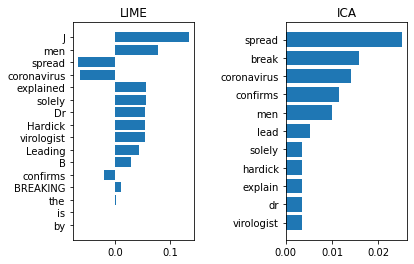

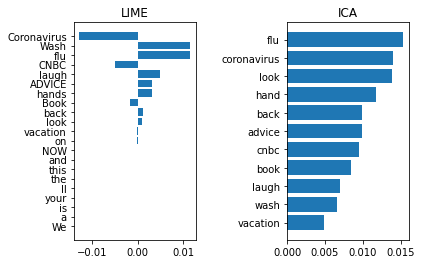

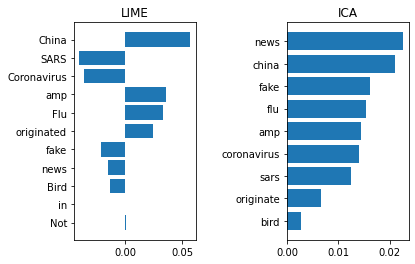

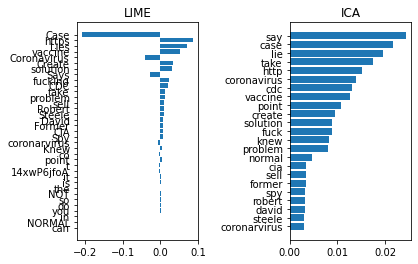

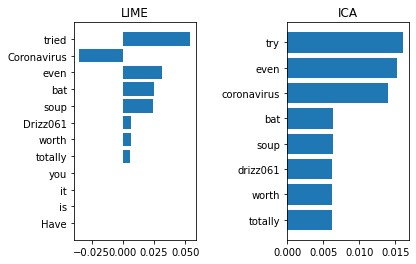

In [48]:
for i in unrel_indx:
    fname = 'tweet{}_plots'.format(i+1)
    
    tweet = tweets['Tweet'][i]
    num_words = len(re.split("\W+", tweet))
    exp = explainer.explain_instance(tweet, c.predict_proba, num_features = num_words)
    LIME_words = np.array(exp.as_list())[:,0]
    LIME_vals = np.array(exp.as_list())[:,1]
    LIME_vals = LIME_vals.astype(np.float)
    
    y_pos_LIME = np.arange(len(LIME_vals))
    
    df = termMagDF.loc[get_tweet_words(tweets['Tweet'][i])]
    df.drop_duplicates(inplace = True) # drop duplicate occurrences of same word
    df = df.filter(regex = '^[a-zA-Z0-9]+$', axis = 0) # drop punctuation
    df.sort_values(by = 'rank', inplace = True)
    ICA_vals = df['Avg_Magnitude'].tolist()
    ICA_words = df.index.values.tolist()
    
    y_pos_ICA = np.arange(len(ICA_vals))
    
    fig, axs = plt.subplots(1, 2)
    axs[0].barh(y_pos_LIME, LIME_vals)
    axs[0].set_yticks(y_pos_LIME)
    axs[0].set_yticklabels(LIME_words)
    axs[0].invert_yaxis()  # labels read top-to-bottom
    axs[0].set_title('LIME')
    axs[1].barh(y_pos_ICA, ICA_vals)
    axs[1].set_yticks(y_pos_ICA)
    axs[1].set_yticklabels(ICA_words)
    axs[1].invert_yaxis()  # labels read top-to-bottom
    axs[1].set_title('ICA')
    plt.subplots_adjust(wspace = 0.75)
    plt.savefig(fname, dpi = 300, bbox_inches = 'tight')

## Reliable tweets

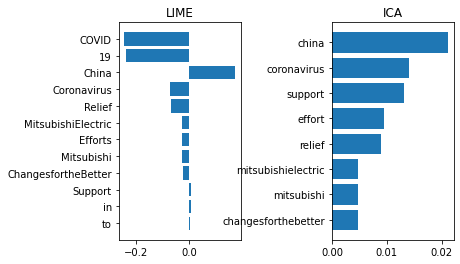

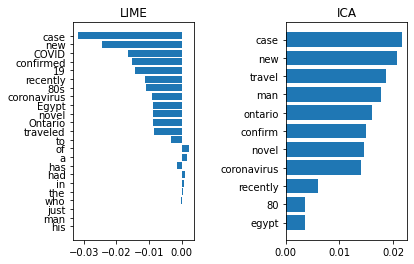

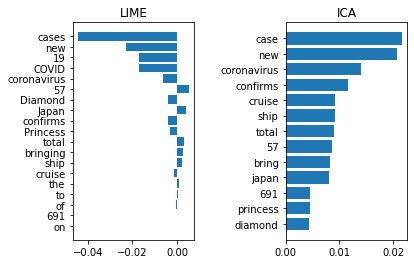

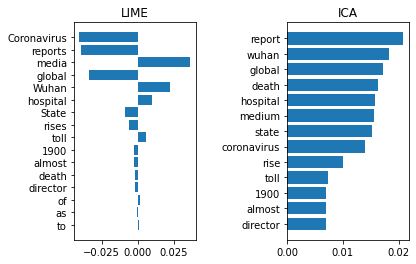

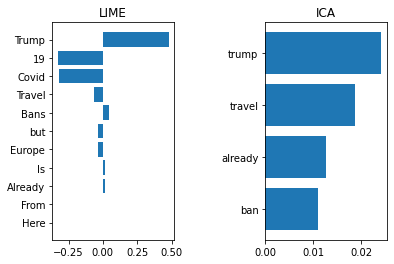

In [49]:
for i in rel_indx:
    fname = 'tweet{}_plots'.format(i+1)
    
    tweet = tweets['Tweet'][i]
    num_words = len(re.split("\W+", tweet))
    exp = explainer.explain_instance(tweet, c.predict_proba, num_features = num_words)
    LIME_words = np.array(exp.as_list())[:,0]
    LIME_vals = np.array(exp.as_list())[:,1]
    LIME_vals = LIME_vals.astype(np.float)
    
    y_pos_LIME = np.arange(len(LIME_vals))
    
    df = termMagDF.loc[get_tweet_words(tweets['Tweet'][i])]
    df.drop_duplicates(inplace = True) # drop duplicate occurrences of same word
    df = df.filter(regex = '^[a-zA-Z0-9]+$', axis = 0) # drop punctuation
    df.sort_values(by = 'rank', inplace = True)
    ICA_vals = df['Avg_Magnitude'].tolist()
    ICA_words = df.index.values.tolist()
    
    y_pos_ICA = np.arange(len(ICA_vals))
    
    fig, axs = plt.subplots(1, 2)
    axs[0].barh(y_pos_LIME, LIME_vals)
    axs[0].set_yticks(y_pos_LIME)
    axs[0].set_yticklabels(LIME_words)
    axs[0].invert_yaxis()  # labels read top-to-bottom
    axs[0].set_title('LIME')
    axs[1].barh(y_pos_ICA, ICA_vals)
    axs[1].set_yticks(y_pos_ICA)
    axs[1].set_yticklabels(ICA_words)
    axs[1].invert_yaxis()  # labels read top-to-bottom
    axs[1].set_title('ICA')
    plt.subplots_adjust(wspace = 0.75)
    plt.savefig(fname, dpi = 300, bbox_inches = 'tight')

# Pairwise Cosine Similarity

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

# define function to print out pairwise cosine similarities for given input string & all word embeddings
def pairwise_cosine_similarity(string, word_embeddings, vocab_list):
    output_list = list()
    strWords = get_tweet_words(string)
    strWords = list(set(strWords))
    embed_df = pd.DataFrame(word_embeddings,
                            index = vocab_list,
                            columns = ['Topic {}'.format(i+1) for i in range(word_embeddings.shape[1])])
    
    strWords_embed = embed_df.loc[strWords]
    
    cos_sim_array = cosine_similarity(np.array(strWords_embed), np.array(strWords_embed))
    
    cos_sim_df = pd.DataFrame(cos_sim_array,
                              index = strWords,
                              columns = strWords)
    
    return cos_sim_df

In [148]:
from scipy.spatial.distance import cosine

# define function to print out pairwise cosine similarities for given input string & all word embeddings
def pcs(string, word_embeddings, vocab_list):
    output_list = list()
    strWords = get_tweet_words(string)
    strWords = list(set(strWords))
    embed_df = pd.DataFrame(word_embeddings,
                            index = vocab_list,
                            columns = ['Topic {}'.format(i+1) for i in range(word_embeddings.shape[1])])
    
    strWords_embed = embed_df.loc[strWords]
    
    for i in range(len(strWords)):
        word_i = strWords[i]
        for j in range(len(strWords)):
            if j > i: # cosine similarity between a word and itself is 1
                word_j = strWords[j]
                u = np.array(strWords_embed.loc[word_i])
                v = np.array(strWords_embed.loc[word_j])
                cos_similarity = 1 - cosine(u, v)
                tup = (word_i, word_j, cos_similarity)
                output_list.append(tup)
                
    return output_list

## Reliable Tweets

In [183]:
for i in rel_indx:
    fname = 'tweet{}_pcs.csv'.format(i+1)
    print('Tweet {}'.format(i+1))
    tweet = tweets['Tweet'][i]
    pcs_results = pcs(tweet, embeddings, cm.vocabulary)
    
    pcs_df = pd.DataFrame({'term1': [tup[0] for tup in pcs_results],
                           'term2': [tup[1] for tup in pcs_results],
                           'cos_sim': [tup[2] for tup in pcs_results]})
    
    pcs_df['mag_assoc'] = abs(pcs_df['cos_sim'])
    pcs_df.sort_values(by = 'mag_assoc', ascending = False, inplace = True, ignore_index = True)
    final_df = pcs_df[['term1','term2','cos_sim']]
    final_df.to_csv(fname)
    display(final_df)
    print('\n'*2)

Tweet 390


,term1,term2,cos_sim
0,changesforthebetter,mitsubishielectric,1.000000
1,mitsubishi,mitsubishielectric,1.000000
2,mitsubishi,changesforthebetter,1.000000
3,(,),0.995539
4,<START>,<END>,0.971302
...,...,...,...
86,#,),-0.007957
87,effort,<END>,0.007744
88,effort,coronavirus,0.007101
89,<START>,relief,-0.003762





Tweet 403


,term1,term2,cos_sim
0,80,egypt,1.000000
1,(,),0.995539
2,<START>,<END>,0.971302
3,<START>,coronavirus,0.858336
4,<END>,coronavirus,0.841320
...,...,...,...
131,<END>,novel,-0.004507
132,80,covid-19,0.004340
133,covid-19,egypt,0.004340
134,<START>,recently,0.002491





Tweet 411


,term1,term2,cos_sim
0,diamond,princess,0.999361
1,<START>,<END>,0.971302
2,cruise,ship,0.868356
3,<START>,coronavirus,0.858336
4,<END>,coronavirus,0.841320
...,...,...,...
166,cruise,",",0.003914
167,",",691,0.003581
168,ship,<END>,-0.003040
169,",",japan,0.000920





Tweet 473


,term1,term2,cos_sim
0,1900,director,1.000000
1,almost,1900,1.000000
2,almost,director,1.000000
3,<START>,<END>,0.971302
4,<START>,coronavirus,0.858336
...,...,...,...
115,director,coronavirus,0.003430
116,wuhan,<START>,0.003179
117,:,toll,-0.002728
118,toll,coronavirus,0.001610





Tweet 518


,term1,term2,cos_sim
0,<START>,<END>,0.971302
1,europe—but,ban,0.685263
2,europe—but,already,0.568337
3,covid-19,<END>,0.388189
4,<START>,covid-19,0.373068
5,europe—but,travel,0.314230
6,travel,ban,0.215009
7,ban,already,0.196426
8,<START>,trump,0.182502
9,ban,trump,0.173137


## Unreliable Tweets

In [184]:
for i in unrel_indx:
    fname = 'tweet{}_pcs.csv'.format(i+1)
    print('Tweet {}'.format(i+1))
    tweet = tweets['Tweet'][i]
    pcs_results = pcs(tweet, embeddings, cm.vocabulary)
    
    pcs_df = pd.DataFrame({'term1': [tup[0] for tup in pcs_results],
                           'term2': [tup[1] for tup in pcs_results],
                           'cos_sim': [tup[2] for tup in pcs_results]})
    
    pcs_df['mag_assoc'] = abs(pcs_df['cos_sim'])
    pcs_df.sort_values(by = 'mag_assoc', ascending = False, inplace = True, ignore_index = True)
    final_df = pcs_df[['term1','term2','cos_sim']]
    final_df.to_csv(fname)
    display(final_df)
    print('\n'*2)

Tweet 124


,term1,term2,cos_sim
0,solely,virologist,1.000000
1,dr,b.j,1.000000
2,dr,virologist,1.000000
3,solely,dr,1.000000
4,hardick,virologist,1.000000
...,...,...,...
115,dr,coronavirus,0.001246
116,solely,coronavirus,0.001246
117,hardick,coronavirus,0.001246
118,explain,coronavirus,0.001246





Tweet 170


,term1,term2,cos_sim
0,<START>,<END>,0.971302
1,laugh,vacation,0.887301
2,<START>,coronavirus,0.858336
3,<END>,coronavirus,0.841320
4,laugh,wash,0.826950
...,...,...,...
115,cnbc,coronavirus,-0.002553
116,flu,<END>,-0.002081
117,back,<START>,-0.001867
118,flu,<START>,0.001135





Tweet 246


,term1,term2,cos_sim
0,<START>,<END>,0.971302
1,<START>,coronavirus,0.858336
2,coronavirus,<END>,0.841320
3,;,amp,0.720914
4,originate,bird,0.680055
...,...,...,...
100,news,;,0.003368
101,china,sars,0.002425
102,flu,<END>,-0.002081
103,flu,<START>,0.001135





Tweet 267


,term1,term2,cos_sim
0,robert,spy,0.999982
1,cia,former,0.999886
2,robert,david,0.999846
3,david,spy,0.999820
4,t.co14xwp6jfoa,steele,0.999375
...,...,...,...
430,fuck,:,-0.001802
431,vaccine,cdc,-0.001757
432,.,http,-0.001278
433,normal,:,0.000885





Tweet 279


,term1,term2,cos_sim
0,drizz061,totally,1.000000
1,soup,bat,1.000000
2,totally,worth,1.000000
3,drizz061,worth,1.000000
4,<START>,<END>,0.971302
...,...,...,...
61,totally,coronavirus,0.014614
62,drizz061,coronavirus,0.014614
63,bat,coronavirus,0.011126
64,soup,coronavirus,0.011126


# Cluster Word Embeddings

In [79]:
from sklearn.cluster import KMeans

In [185]:
km = KMeans(n_clusters = 4)
clustered_embeddings = km.fit_transform(embeddings)
cluster_labs = km.labels_

In [186]:
words = [key for key in cm.vocabulary.keys()]

term_clusters = pd.DataFrame({"terms": words,
                              "cluster": cluster_labs})
term_clusters['cluster'].value_counts()

3    2294
2      14
1      10
0       9
Name: cluster, dtype: int64

In [187]:
for el in term_clusters['cluster'].unique():
    print("Cluster {}:".format(el+1))
    #print(term_clusters[term_clusters.cluster == el]['terms'])
    [print(word) for word in term_clusters[term_clusters.cluster == el]['terms']]
    print("\n"*2)

Cluster 4:
!
#
(
)
,
-
--
.
..
...
....
1
1,600
1,975
1-
10
10,000
100
1000
10:30
10:30am
10th
11
115
118,000
12
133
14
14:21
1500
16-18
17
170
18
19
1900
19th
1:30
1b
1st
2
2-
2.5
20
20-40s
200
2019
2019-ncovid
2019ncov
2020
2021
21
22
23
24
24thminute
25
26
27
2700
29th
21
3
3,000
3.4
30
30.8
32
3200
36
366
38
39
4
40
40-70
409k
42nd
43
4600
48
5
50
54,000
56,000
57
577
5:30pm
5g
5th
6
6,000
60
600
60m
61k
66
680news
680newsweather
691
6ixside
7
7,800
71
75
76
7th
8
8,400
8.3
80
800
80yrs
88-year-old
8th
9
90
90,000
99
9pm
:
;
<END>
<START>
?
abandon
abc
ability
aboard
absolutley
abuse
accept
accord
account
accountability
accurate
accuse
achieve
across
act
action
acute
ad
adamsmiller
adapt
addendum
addition
additional
address
administration
admit
admits
advice
advises
afford
affordable
afp
afraid
african
afternoon
age
agency
agenda
ago
agrabah
agree
ai
aim
air
aircraft
airlift
airline
airport
aka
al
aladdin
alarm
alarmed
alberta
alert
allow
almost
already
also
although
always
am740


morning
moronavirus
moroninchief
mortality
mortgage
mosquito
motel
move
msc2020
much
multinational
mulvaney
must
mustread
muzzle
myocardial
mysterious
n.y.
na
nadine
name
nasa
nasdaq
nation
national
nationalpost
nationwide
natpostradio
nature
navy
nazi
nba
ne
near
nearly
need
negative
negatively
neighbor
nervous
net
netherlands
never
new
newmarket
news
next
nh
night
nit
nixed
non-stop
none
nonsense
norm
normal
north
northern
northkoreas
norwegian
nose
note
notice
nov
novel
nsc
nuclear
number
nursejcallahan
nvidia
nyt
nytimes
oatmeal
obama
occasion
occur
ocean
ocl
oct
offend
offensive
offer
offering
offhandedly
office
officer
official
officially
often
oil
old
olympic
olympicpodcast
olympics
one
ongoing
online
onpoli
onset
ontario
ontpoli
open
operation
opinion
option
orange
orchestrate
order
oregon
organization
origin
originally
originate
others
ottawa
ottnews
ought
outbreak
outpace
outrageous
outside
over-reliance
overestimate
overnight
overreaction
overseas
own
owner
page
pakistani
pa

In [188]:
pca = PCA(n_components = 2)
std_scaler = StandardScaler()
embed_std = std_scaler.fit_transform(embeddings)
embed_pca = pca.fit_transform(embed_std)

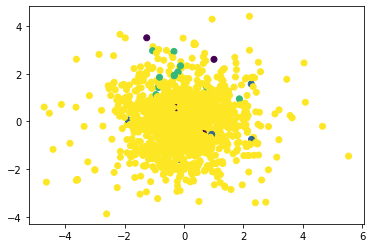

In [189]:
df = pd.DataFrame(embed_pca,
                  index = cm.vocabulary,
                  columns = ['PCA Comp {}'.format(i+1) for i in range(2)])

x = df['PCA Comp 1']
y = df['PCA Comp 2']

plt.scatter(x, y, c = cluster_labs)
plt.show()

/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 62222 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 62222 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


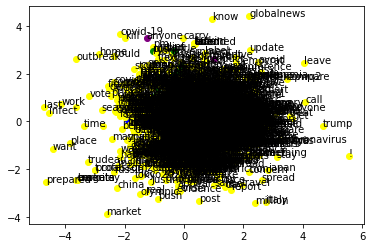

In [190]:
color_dict = {0: "purple",
              1: "blue",
              2: "green",
              3: "yellow",
              4: "red",
              5: "orange",
              6: "pink"}

for i, word in enumerate(words):
    
    x = df['PCA Comp 1'][i]
    y = df['PCA Comp 2'][i]

    plt.scatter(x, y, color = color_dict[cluster_labs[i]])
    plt.text(x, y, word)